# Wave amplitude blowing up for large `t_total`. #6

This ipython notebook reproduces the bug discussed in `github` issue [Quazartech/DG_Maxwell Issue #6](https://github.com/QuazarTech/DG_Maxwell/issues/6)
in which the wave function was increasing with time and eventually blowing up exponentially after some time
$dt$.

In this notebook I have re-written the functions for calculating the $A$ matrix, $b$ matrix
and time evolution function using the already tested basic functions.

### Note
Use the following command to get the documentation of a function
```
    <function>?
```
For example, if you want to look at the documentation of the function `gvar.populateGlobalVariables`, in an empty
cell type `gvar.populateGlobalVariables?`.

In [1]:
import subprocess

from matplotlib import pyplot as plt
import numpy as np
from tqdm import trange
import arrayfire as af
# Available backends with arrayfire
# 1. cuda
# 2. opencl
# 3. cpu
af.set_backend('cuda')


# Contains the global variables for the functions.
from app import global_variables as gvar
# Contains the functions for 1D wave equation solver.
from app import wave_equation

plt.rcParams['figure.figsize'] = 9.6, 6.
plt.rcParams['figure.dpi'] = 100
plt.rcParams['image.cmap'] = 'jet'
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['font.size'] = 20
plt.rcParams['font.sans-serif'] = 'serif'
plt.rcParams['text.usetex'] = True
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['axes.titlesize'] = 'medium'
plt.rcParams['axes.labelsize'] = 'medium'
plt.rcParams['xtick.major.size'] = 8
plt.rcParams['xtick.minor.size'] = 4
plt.rcParams['xtick.major.pad'] = 8
plt.rcParams['xtick.minor.pad'] = 8
plt.rcParams['xtick.color'] = 'k'
plt.rcParams['xtick.labelsize'] = 'medium'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.major.size'] = 8
plt.rcParams['ytick.minor.size'] = 4
plt.rcParams['ytick.major.pad'] = 8
plt.rcParams['ytick.minor.pad'] = 8
plt.rcParams['ytick.color'] = 'k'
plt.rcParams['ytick.labelsize'] = 'medium'
plt.rcParams['ytick.direction'] = 'in'


In [2]:
# Polulate all the global variable before proceeding for
# time evolution.

gvar.populateGlobalVariables(Number_of_LGL_pts = 8,
                             Number_of_elements = 10,
                             c_ = 4.,
                             c_lax_ = 4.,
                             total_time_ = 1.05)

In [3]:
# In case of 1D wave eqaution with elements formed by dividing the
# domain into equally spaced points, the A matrix remains same for
# all the elements, so we will calculate the A matrix once.

# However, if the elements are of different sizes, we will need to
# calculate the A matrix for each elements individually.

A_inverse = af.lapack.inverse(wave_equation.A_matrix())

# Time evolution of the wave equation
The set of linear equations needed to find the $u$ for the next time
step is given by

$$
    Au^{n + 1} = Au^n + b 
$$

$$
    u^{n + 1} = u^n + A^{-1}b
$$

where,

$A$ is the A matrix

$u^{n}$ is the $u$ at the $n^{th}$ time step.

$b$ is the b vector.

In [4]:
# Code for finding the time evolution of the wave

for t_n in trange(0, gvar.time.shape[0] - 1):
    gvar.u[:, :, t_n + 1] =  gvar.u[:, :, t_n] \
                           + af.blas.matmul(A_inverse,
                                            wave_equation.b_vector(t_n))


100%|██████████| 26195/26195 [01:14<00:00, 350.59it/s]


In [12]:
# Creates a folder `results/1D_Wave_images` and stores the
# plot of `u` in time there at time steps of 100.

approximate_1_s       = (int(1 / gvar.delta_t) * gvar.delta_t)
analytical_u_after_1s = np.e ** (-(gvar.element_LGL - gvar.c
                                * (1 - approximate_1_s)) ** 2 / 0.4 ** 2)

af.display(analytical_u_after_1s, 10)
af.display(gvar.u[:, :, int(1 / gvar.delta_t)], 10)
af.display(gvar.u[:, :, 0], 10)

subprocess.run(['mkdir', 'results/1D_Wave_images'])

for t_n in trange(0, gvar.time.shape[0] - 1):
    if t_n % 100 == 0:
        fig = plt.figure()
        x   = gvar.element_LGL
        y   = gvar.u[:, :, t_n]

        plt.plot(x, y)
        plt.xlabel('x')
        plt.ylabel('Amplitude')
        plt.title('Time = %f' % (t_n * gvar.delta_t))
        fig.savefig('results/1D_Wave_images/%04d' %(t_n / 100) + '.png')
        plt.close('all')


100%|██████████| 26195/26195 [00:51<00:00, 506.53it/s]


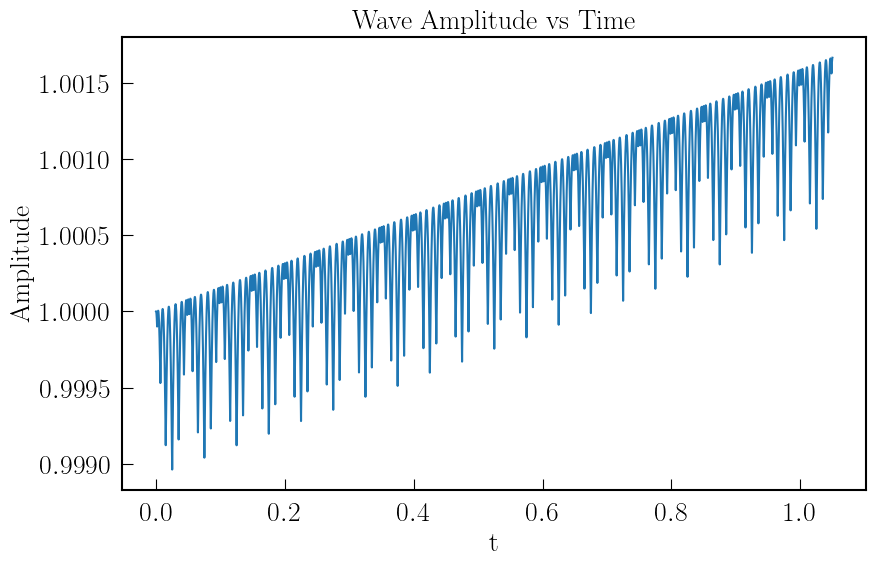

In [11]:
# Loops through time and finds the maximum value of the `u`
# for each time step and stores it in the variable `wave_amplitude`
# and plots it w.r.t time.

wave_amplitude = []

for t_i in np.arange(u_clax_is_c.shape[2]):  
    wave_amplitude.append(af.max(gvar.u[:, :, t_i]))

wave_amplitude = np.array(wave_amplitude)

plt.title('Wave Amplitude vs Time')
plt.xlabel('t')
plt.ylabel('Amplitude')

plot_ampl_clax_is_c = plt.plot(gvar.time, wave_amplitude)
# plt.legend()
plt.show()